In [1]:
%pip install -q git+https://github.com/huggingface/transformers.git

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install -q datasets seqeval

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install accelerate -U

Note: you may need to restart the kernel to use updated packages.


In [25]:
from datasets import load_dataset

# this dataset uses the new Image feature :)
dataset = load_dataset("layoutlmv3.py")

c:\Users\LENOVO\Desktop\layoutlmv3_project\.venv\Lib\site-packages\datasets\load.py:926: FutureWarning: The repository for layoutlmv3 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at layoutlmv3.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [26]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image_path', 'image'],
        num_rows: 3
    })
    test: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image_path', 'image'],
        num_rows: 2
    })
})

In [27]:
dataset["train"].features

{'id': Value(dtype='string', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'bboxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['num_facture', 'date_facture', 'fournisseur', 'client', 'mat_client', 'mat_fournisseur', 'tva', 'pourcentage_tva', 'remise', 'pourcentage_remise', 'timbre', 'fodec', 'ttc', 'devise', 'net_ht'], id=None), length=-1, id=None),
 'image_path': Value(dtype='string', id=None),
 'image': Image(decode=True, id=None)}

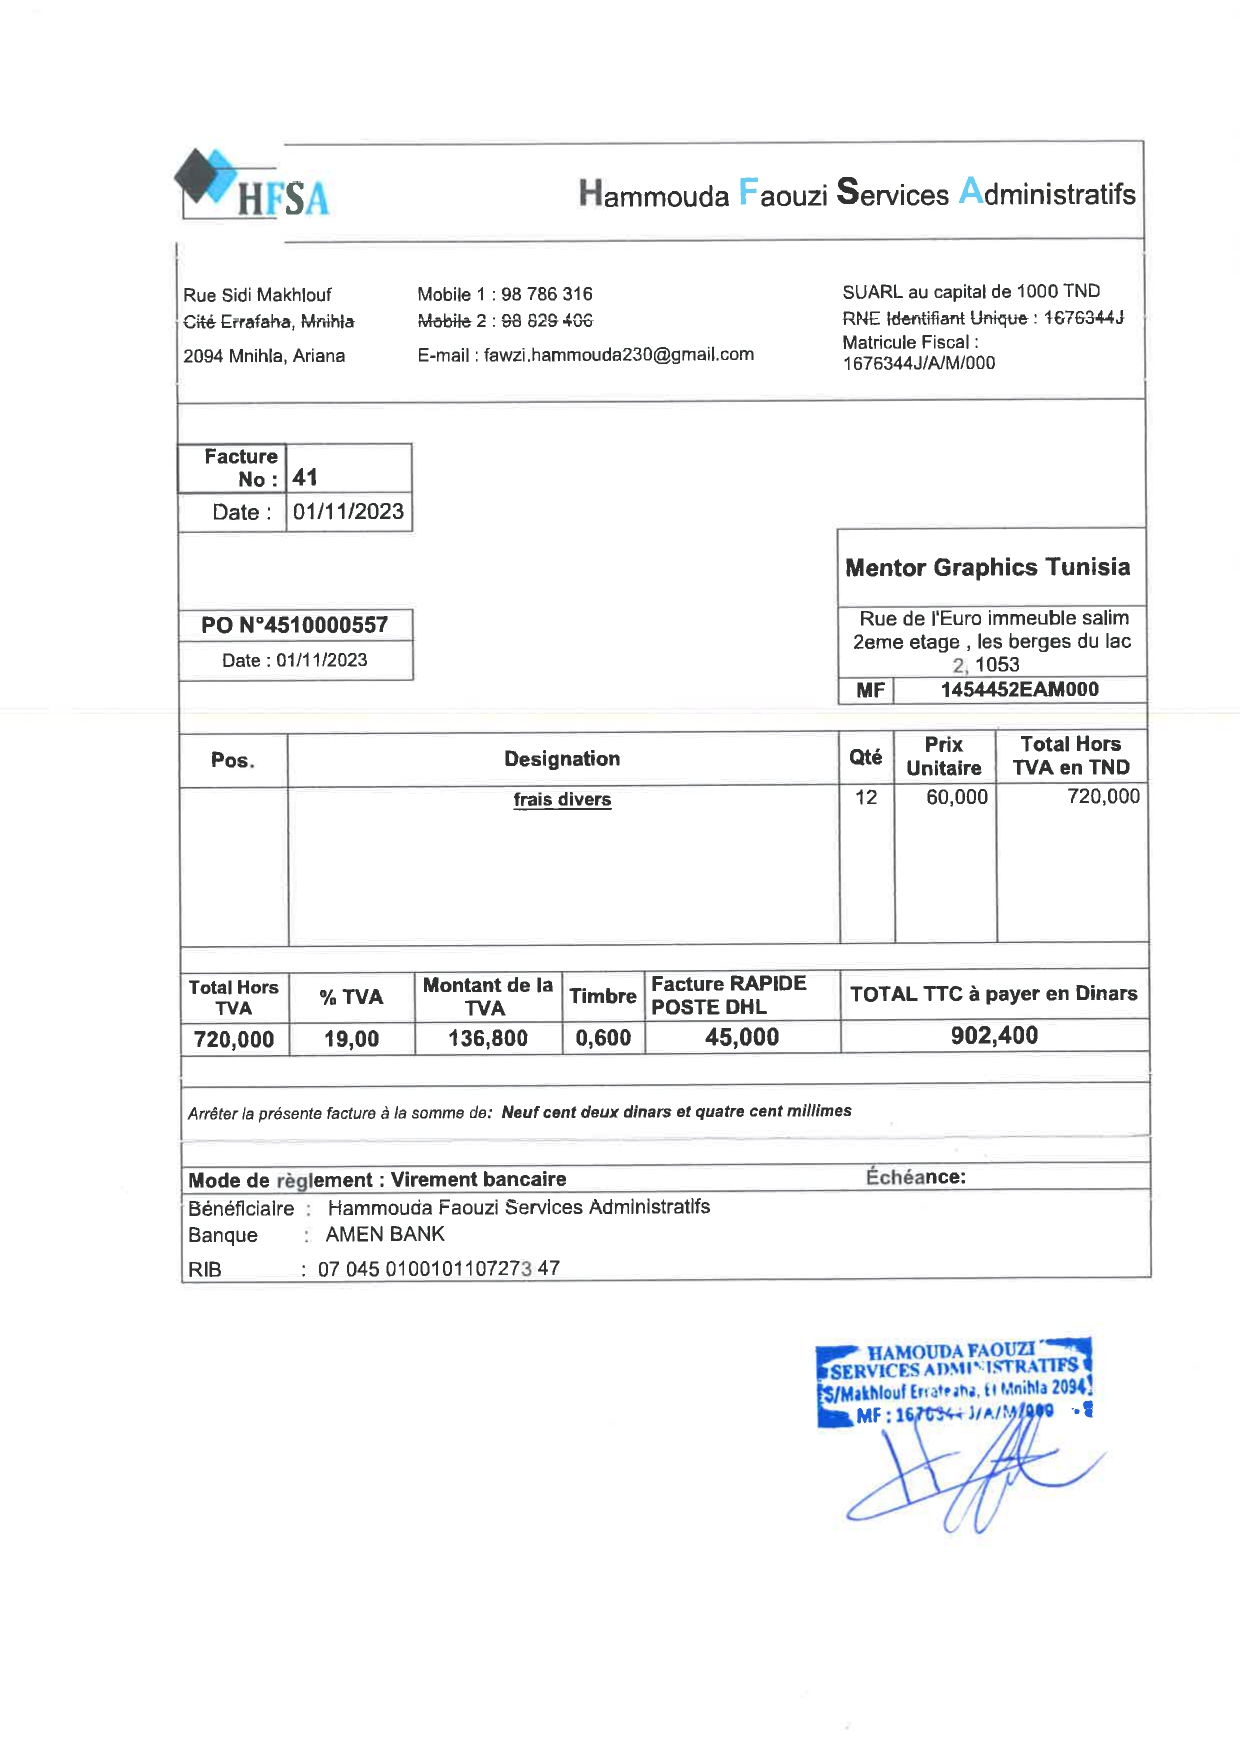

In [28]:
example = dataset["train"][0]
example["image"]

In [29]:
qq = example["image"].convert("RGB")
qq.size

(1240, 1754)

In [30]:
from  PIL import Image
qqq = Image.open(r"C:\Users\LENOVO\Desktop\layoutlmv3_project\layoutlmv3\8d20e66c-Delta_Sport_762022_doc2100000287-page-00001.jpg").convert("RGB")
qqq.size

(1241, 1755)

In [31]:
words, boxes, ner_tags = example["tokens"], example["bboxes"], example["ner_tags"]
print(words)
print(boxes)
print(ner_tags)

['Hammouda', 'Faouzi', 'Services', 'Administratifs', '1676344J/A/M/000', '|01/11/2023', 'Mentor', 'Graphics', 'Tunisia', '1454452EAM000', 'TND', '0,600', '19,00', '136,800', '902,400', '720,000']
[[467, 102, 587, 118], [596, 101, 666, 118], [675, 100, 765, 117], [773, 100, 916, 116], [680, 202, 802, 210], [237, 286, 325, 296], [682, 318, 747, 328], [753, 317, 837, 331], [842, 317, 911, 328], [759, 388, 886, 397], [878, 432, 911, 441], [464, 586, 508, 598], [262, 587, 305, 598], [362, 586, 425, 598], [767, 584, 837, 596], [156, 587, 220, 599]]
[2, 2, 2, 2, 5, 1, 3, 3, 3, 4, 13, 10, 7, 6, 12, 14]


In [32]:
from transformers import AutoProcessor

# we'll use the Auto API here - it will load LayoutLMv3Processor behind the scenes,
# based on the checkpoint we provide from the hub
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

In [33]:
from datasets.features import ClassLabel

features = dataset["train"].features
column_names = dataset["train"].column_names
image_column_name = "image"
text_column_name = "tokens"
boxes_column_name = "bboxes"
label_column_name = "ner_tags"

# In the event the labels are not a `Sequence[ClassLabel]`, we will need to go through the dataset to get the
# unique labels.
def get_label_list(labels):
    unique_labels = set()
    for label in labels:
        unique_labels = unique_labels | set(label)
    label_list = list(unique_labels)
    label_list.sort()
    return label_list

if isinstance(features[label_column_name].feature, ClassLabel):
    label_list = features[label_column_name].feature.names
    # No need to convert the labels since they are already ints.
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
else:
    label_list = get_label_list(dataset["train"][label_column_name])
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
num_labels = len(label_list)

In [34]:
print(label_list)

['num_facture', 'date_facture', 'fournisseur', 'client', 'mat_client', 'mat_fournisseur', 'tva', 'pourcentage_tva', 'remise', 'pourcentage_remise', 'timbre', 'fodec', 'ttc', 'devise', 'net_ht']


In [35]:
print(id2label)

{0: 'num_facture', 1: 'date_facture', 2: 'fournisseur', 3: 'client', 4: 'mat_client', 5: 'mat_fournisseur', 6: 'tva', 7: 'pourcentage_tva', 8: 'remise', 9: 'pourcentage_remise', 10: 'timbre', 11: 'fodec', 12: 'ttc', 13: 'devise', 14: 'net_ht'}


In [36]:
def prepare_examples(examples):
  images = examples[image_column_name]
  words = examples[text_column_name]
  boxes = examples[boxes_column_name]
  word_labels = examples[label_column_name]

  encoding = processor(images, words, boxes=boxes, word_labels=word_labels,
                       truncation=True, padding="max_length")

  return encoding

In [37]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D, Dataset

# we need to define custom features for `set_format` (used later on) to work properly
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})

train_dataset = dataset["train"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)
eval_dataset = dataset["test"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)

In [38]:
train_dataset

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 3
})

In [39]:
example = train_dataset[0]
processor.tokenizer.decode(example["input_ids"])

'<s> Hammouda Faouzi Services Administratifs 1676344J/A/M/000 |01/11/2023 Mentor Graphics Tunisia 1454452EAM000 TND 0,600 19,00 136,800 902,400 720,000</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

In [40]:
train_dataset.set_format("torch")

In [41]:
import torch

example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)

pixel_values torch.Size([3, 224, 224])
input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])


In [42]:
eval_dataset

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 2
})

In [43]:
processor.tokenizer.decode(eval_dataset[0]["input_ids"])

'<s> TUN-043 January 2023 1375568A/A/M/000 GIE STREICHER-BOUCHAMAOUI STE Ridha RC CONSULTING TND 43 200.000 15 709.000 1.000</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><p

In [44]:
for id, label in zip(train_dataset[0]["input_ids"], train_dataset[0]["labels"]):
  print(processor.tokenizer.decode([id]), label.item())

<s> -100
 Hamm 2
oud -100
a -100
 Fa 2
ou -100
zi -100
 Services 2
 Administ 2
rat -100
if -100
s -100
 16 5
76 -100
344 -100
J -100
/ -100
A -100
/ -100
M -100
/ -100
000 -100
 | 1
01 -100
/ -100
11 -100
/ -100
20 -100
23 -100
 Ment 3
or -100
 Graphics 3
 Tunisia 3
 14 4
54 -100
452 -100
E -100
AM -100
000 -100
 T 13
ND -100
 0 10
, -100
600 -100
 19 7
, -100
00 -100
 136 6
, -100
800 -100
 9 12
02 -100
, -100
400 -100
 720 14
, -100
000 -100
</s> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pa

In [45]:
from datasets import load_metric

metric = load_metric("seqeval")

c:\Users\LENOVO\Desktop\layoutlmv3_project\.venv\Lib\site-packages\datasets\load.py:756: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [47]:
import numpy as np

return_entity_level_metrics = False

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

In [48]:
from transformers import LayoutLMv3ForTokenClassification

model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base",
                                                         id2label=id2label,
                                                         label2id=label2id)

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [49]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test",
                                  max_steps=1000,
                                  per_device_train_batch_size=2,
                                  per_device_eval_batch_size=2,
                                  learning_rate=1e-5,
                                  evaluation_strategy="steps",
                                  eval_steps=100,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1")

In [28]:
# !pip install accelerate -U

In [50]:
from transformers.data.data_collator import default_data_collator

# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

In [30]:
trainer.train()

  0%|          | 0/1000 [00:00<?, ?it/s]c:\Users\LENOVO\Desktop\layoutlmv3_project\.venv\Lib\site-packages\transformers\modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 10%|█         | 100/1000 [19:12<2:33:14, 10.22s/it]c:\Users\LENOVO\Desktop\layoutlmv3_project\.venv\Lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: num_facture seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\LENOVO\Desktop\layoutlmv3_project\.venv\Lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: date_facture seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\LENOVO\Desktop\layoutlmv3_project\.venv\Lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: mat_client seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\LENOVO\Desktop\layoutlmv3_proj

{'eval_loss': 1.2882453203201294, 'eval_precision': 0.5238095238095238, 'eval_recall': 0.55, 'eval_f1': 0.5365853658536585, 'eval_accuracy': 0.6, 'eval_runtime': 5.4965, 'eval_samples_per_second': 0.364, 'eval_steps_per_second': 0.182, 'epoch': 50.0}


                                                    
 20%|██        | 200/1000 [36:32<2:10:35,  9.79s/it]

{'eval_loss': 1.2945421934127808, 'eval_precision': 0.42857142857142855, 'eval_recall': 0.45, 'eval_f1': 0.4390243902439024, 'eval_accuracy': 0.5666666666666667, 'eval_runtime': 5.3358, 'eval_samples_per_second': 0.375, 'eval_steps_per_second': 0.187, 'epoch': 100.0}


                                                    
 30%|███       | 300/1000 [54:00<1:56:52, 10.02s/it]

{'eval_loss': 1.4382672309875488, 'eval_precision': 0.5, 'eval_recall': 0.45, 'eval_f1': 0.4736842105263158, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 5.1752, 'eval_samples_per_second': 0.386, 'eval_steps_per_second': 0.193, 'epoch': 150.0}


                                                      
 40%|████      | 400/1000 [1:11:36<1:40:13, 10.02s/it]

{'eval_loss': 1.5831738710403442, 'eval_precision': 0.47368421052631576, 'eval_recall': 0.45, 'eval_f1': 0.46153846153846156, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 5.2974, 'eval_samples_per_second': 0.378, 'eval_steps_per_second': 0.189, 'epoch': 200.0}


 50%|█████     | 500/1000 [1:28:59<1:21:12,  9.74s/it]

{'loss': 0.3192, 'grad_norm': 0.17183761298656464, 'learning_rate': 5e-06, 'epoch': 250.0}


                                                      
 50%|█████     | 500/1000 [1:29:04<1:21:12,  9.74s/it]

{'eval_loss': 1.7243367433547974, 'eval_precision': 0.4090909090909091, 'eval_recall': 0.45, 'eval_f1': 0.4285714285714286, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 5.2293, 'eval_samples_per_second': 0.382, 'eval_steps_per_second': 0.191, 'epoch': 250.0}


c:\Users\LENOVO\Desktop\layoutlmv3_project\.venv\Lib\site-packages\transformers\modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 60%|██████    | 600/1000 [1:46:22<1:05:01,  9.75s/it]c:\Users\LENOVO\Desktop\layoutlmv3_project\.venv\Lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: num_facture seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\LENOVO\Desktop\layoutlmv3_project\.venv\Lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: date_facture seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\LENOVO\Desktop\layoutlmv3_project\.venv\Lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: mat_client seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\LENOVO\Desktop\layoutlmv3_project\.venv\Lib\site-packages\seqeval\me

{'eval_loss': 1.769959807395935, 'eval_precision': 0.4090909090909091, 'eval_recall': 0.45, 'eval_f1': 0.4285714285714286, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 5.1089, 'eval_samples_per_second': 0.391, 'eval_steps_per_second': 0.196, 'epoch': 300.0}


                                                      
 70%|███████   | 700/1000 [2:04:10<1:01:31, 12.31s/it]

{'eval_loss': 1.853521466255188, 'eval_precision': 0.42857142857142855, 'eval_recall': 0.45, 'eval_f1': 0.4390243902439024, 'eval_accuracy': 0.5, 'eval_runtime': 5.1022, 'eval_samples_per_second': 0.392, 'eval_steps_per_second': 0.196, 'epoch': 350.0}


                                                      
 80%|████████  | 800/1000 [2:20:35<30:34,  9.17s/it]

{'eval_loss': 1.8729068040847778, 'eval_precision': 0.42857142857142855, 'eval_recall': 0.45, 'eval_f1': 0.4390243902439024, 'eval_accuracy': 0.5, 'eval_runtime': 4.8553, 'eval_samples_per_second': 0.412, 'eval_steps_per_second': 0.206, 'epoch': 400.0}


                                                    
 90%|█████████ | 900/1000 [2:36:48<15:15,  9.16s/it]

{'eval_loss': 1.882117509841919, 'eval_precision': 0.42857142857142855, 'eval_recall': 0.45, 'eval_f1': 0.4390243902439024, 'eval_accuracy': 0.5, 'eval_runtime': 4.7965, 'eval_samples_per_second': 0.417, 'eval_steps_per_second': 0.208, 'epoch': 450.0}


100%|██████████| 1000/1000 [2:52:38<00:00,  9.26s/it]

{'loss': 0.0119, 'grad_norm': 0.07006838917732239, 'learning_rate': 0.0, 'epoch': 500.0}


                                                     
100%|██████████| 1000/1000 [2:52:43<00:00,  9.26s/it]

{'eval_loss': 1.869916558265686, 'eval_precision': 0.4090909090909091, 'eval_recall': 0.45, 'eval_f1': 0.4285714285714286, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 4.9811, 'eval_samples_per_second': 0.402, 'eval_steps_per_second': 0.201, 'epoch': 500.0}


100%|██████████| 1000/1000 [2:52:46<00:00, 10.37s/it]

{'train_runtime': 10366.2663, 'train_samples_per_second': 0.193, 'train_steps_per_second': 0.096, 'train_loss': 0.1655409073829651, 'epoch': 500.0}


TrainOutput(global_step=1000, training_loss=0.1655409073829651, metrics={'train_runtime': 10366.2663, 'train_samples_per_second': 0.193, 'train_steps_per_second': 0.096, 'train_loss': 0.1655409073829651, 'epoch': 500.0})

In [31]:
trainer.evaluate()

c:\Users\LENOVO\Desktop\layoutlmv3_project\.venv\Lib\site-packages\transformers\modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\LENOVO\Desktop\layoutlmv3_project\.venv\Lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: num_facture seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\LENOVO\Desktop\layoutlmv3_project\.venv\Lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: date_facture seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\LENOVO\Desktop\layoutlmv3_project\.venv\Lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: mat_client seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\LENOVO\Desktop\layoutlmv3_project\.venv\Lib\site-packages\seqeval\metrics\sequence_la

{'eval_loss': 1.7243367433547974,
 'eval_precision': 0.4090909090909091,
 'eval_recall': 0.45,
 'eval_f1': 0.4285714285714286,
 'eval_accuracy': 0.5333333333333333,
 'eval_runtime': 4.9908,
 'eval_samples_per_second': 0.401,
 'eval_steps_per_second': 0.2,
 'epoch': 500.0}

In [51]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained("layoutlmv3_app/test/checkpoint-1000")

In [52]:
example = dataset["test"][0]
print(example.keys())

dict_keys(['id', 'tokens', 'bboxes', 'ner_tags', 'image_path', 'image'])


In [53]:
image = example["image"]
words = example["tokens"]
boxes = example["bboxes"]
word_labels = example["ner_tags"]

encoding = processor(image, words, boxes=boxes, word_labels=word_labels, return_tensors="pt")
for k,v in encoding.items():
  print(k,v.shape)

input_ids torch.Size([1, 53])
attention_mask torch.Size([1, 53])
bbox torch.Size([1, 53, 4])
labels torch.Size([1, 53])
pixel_values torch.Size([1, 3, 224, 224])


In [54]:
with torch.no_grad():
  outputs = model(**encoding)

c:\Users\LENOVO\Desktop\layoutlmv3_project\.venv\Lib\site-packages\transformers\modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [55]:
logits = outputs.logits
logits.shape

torch.Size([1, 53, 15])

In [56]:
predictions = logits.argmax(-1).squeeze().tolist()
print(predictions)

[2, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 13, 13, 6, 6, 10, 10, 6, 12, 14, 10, 10, 10, 10, 10, 2]


In [57]:
labels = encoding.labels.squeeze().tolist()
print(labels)

[-100, 0, -100, -100, -100, 1, 1, -100, 4, -100, -100, -100, -100, -100, -100, -100, -100, -100, 3, -100, 3, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 2, 2, -100, 2, 2, -100, -100, 13, -100, 14, 14, -100, -100, 12, 12, -100, -100, -100, 10, -100, -100, -100]


In [58]:
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

token_boxes = encoding.bbox.squeeze().tolist()
width, height = image.size

true_predictions = [model.config.id2label[pred] for pred, label in zip(predictions, labels) if label != - 100]
true_labels = [model.config.id2label[label] for prediction, label in zip(predictions, labels) if label != -100]
true_boxes = [unnormalize_box(box, width, height) for box, label in zip(token_boxes, labels) if label != -100]

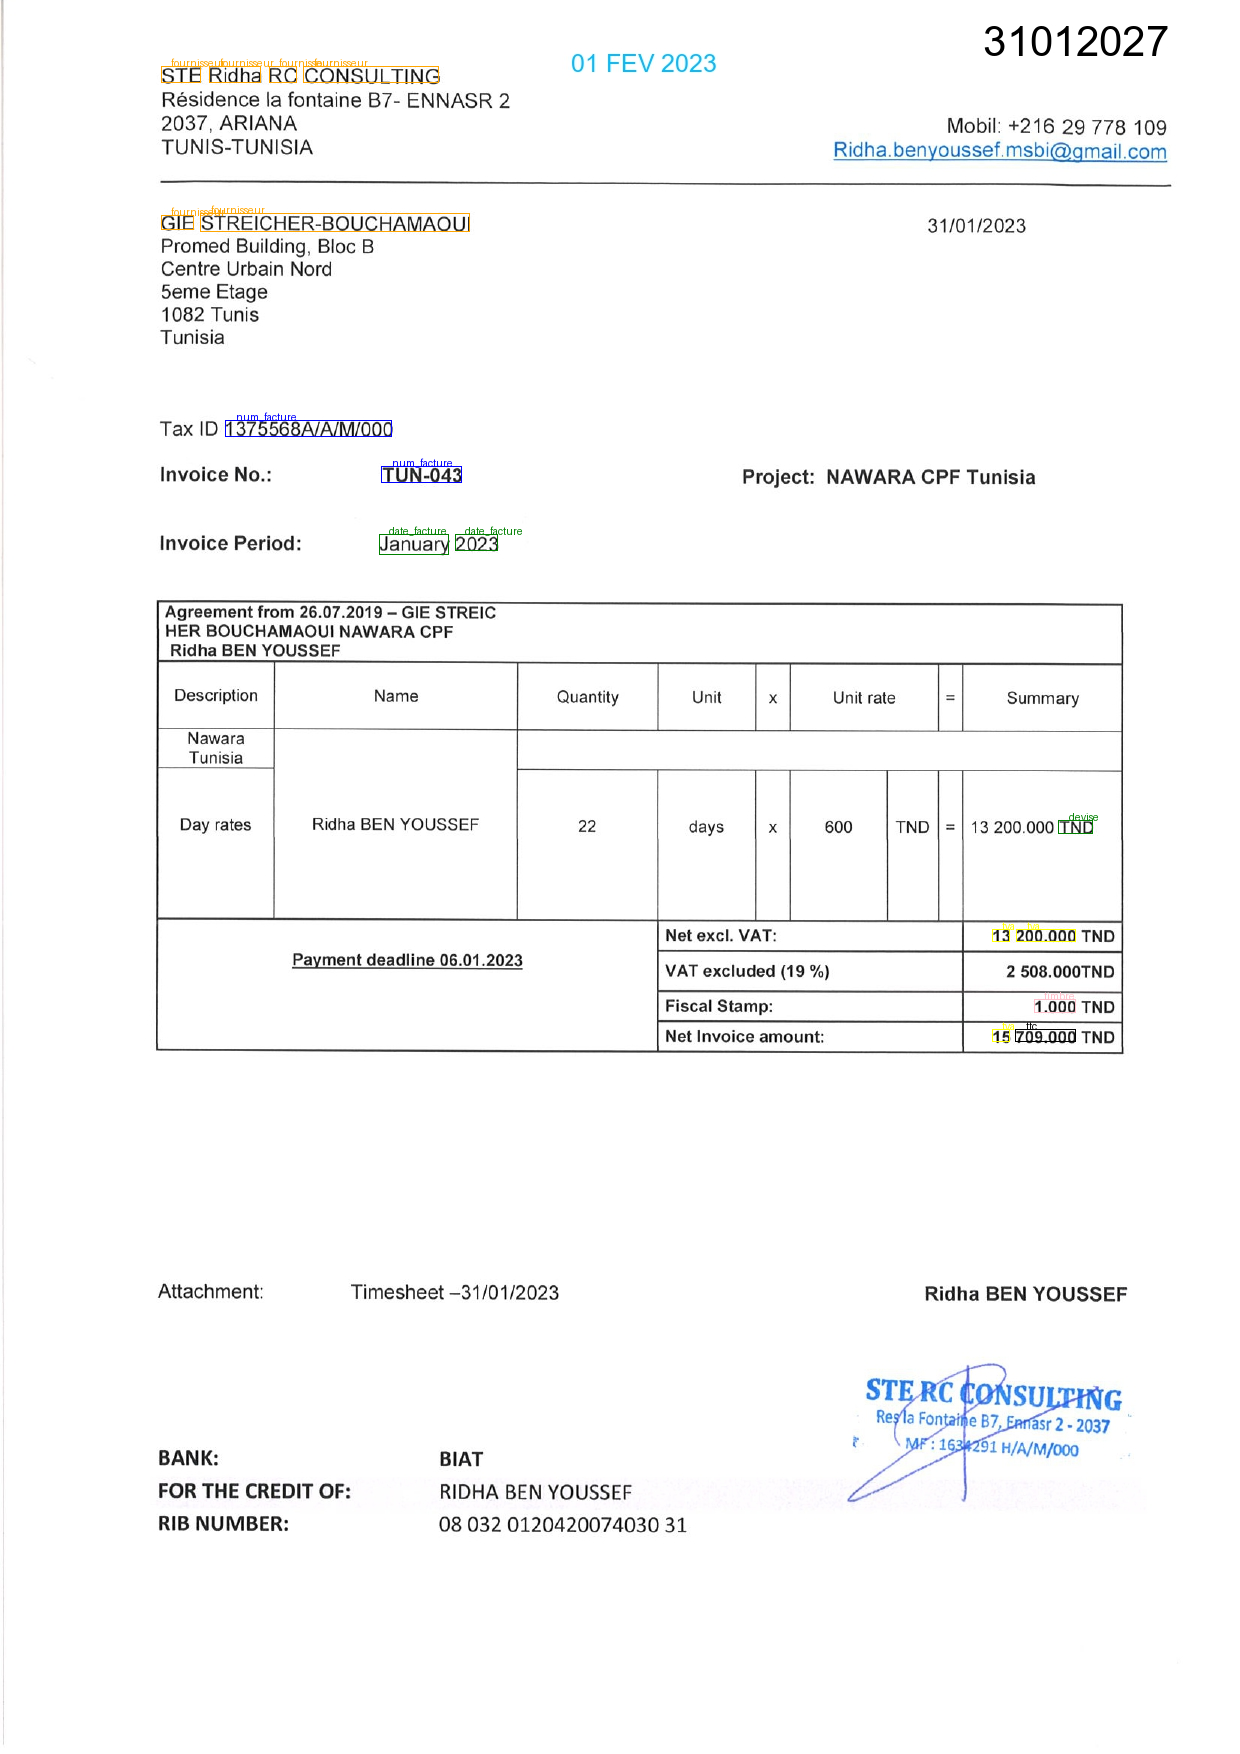

In [59]:
from PIL import ImageDraw, ImageFont
# Prompt the user to input the image file path
#image_path = input("./deltasport.png ")

# Load the image
#image = Image.open(image_path)
image = image.convert("RGB")

draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
    label = label
    if not label:
      return 'other'
    return label

label2color = {'num_facture':'blue', 'date_facture':'green', 'fournisseur':'orange', 'client':'red', 'mat_client':'red', 'mat_fournisseur':'orange','tva':'yellow', 'pourcentage_tva':'yellow', 'remise':'purple', 'pourcentage_remise':'purple', 'timbre':'pink', 'fodec':'pink','ttc':'black', 'devise':'green', 'net_ht':'black'}

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

image

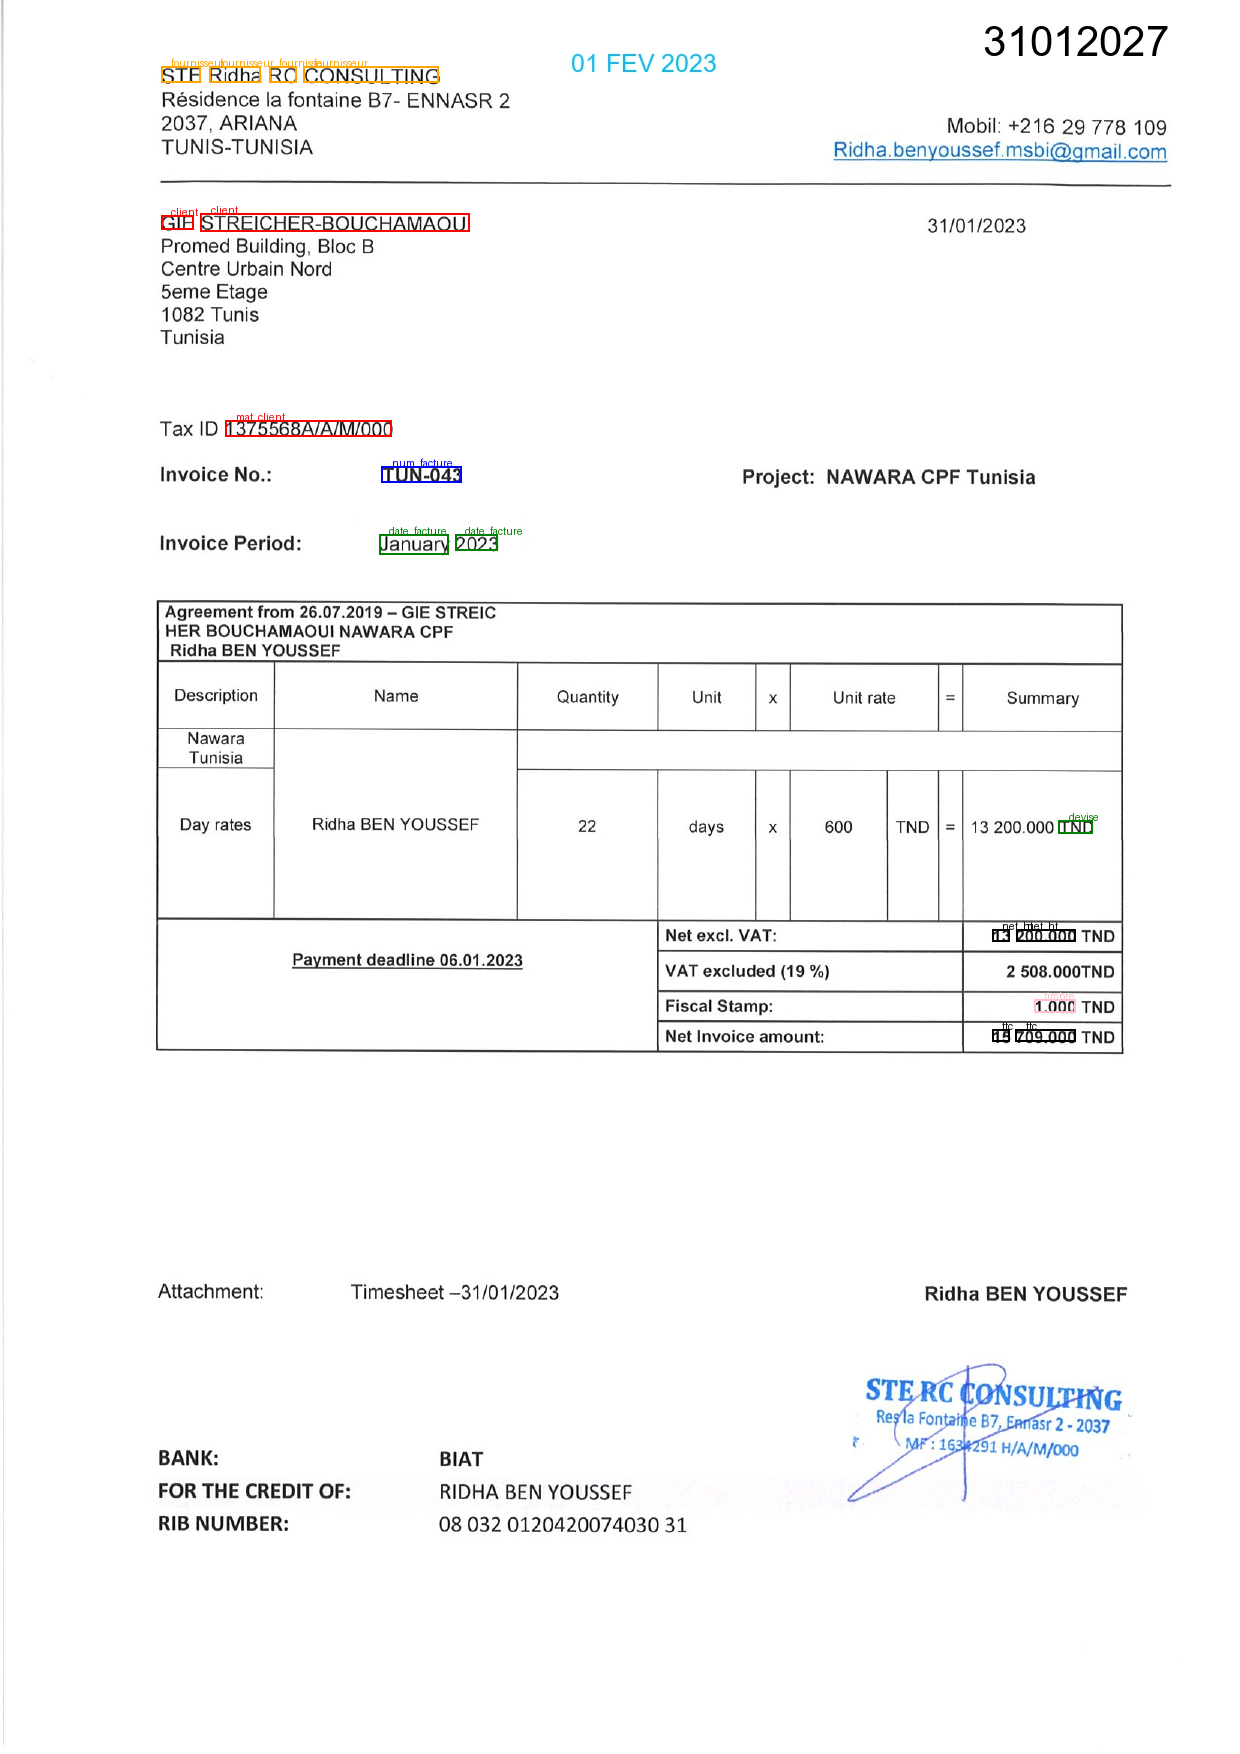

In [60]:
image = example["image"]
image = image.convert("RGB")

draw = ImageDraw.Draw(image)

for word, box, label in zip(example['tokens'], example['bboxes'], example['ner_tags']):
  actual_label = iob_to_label(id2label[label]).lower()
  box = unnormalize_box(box, width, height)
  draw.rectangle(box, outline=label2color[actual_label], width=2)
  draw.text((box[0] + 10, box[1] - 10), actual_label, fill=label2color[actual_label], font=font)

image

In [61]:
# Initialize a list to store the extracted values
extracted_values = []

# Iterate over words, boxes, and labels to print them out
for word, box, label in zip(example['tokens'], example['bboxes'], example['ner_tags']):
    actual_label = iob_to_label(id2label[label]).lower()
    box = unnormalize_box(box, width, height)
    
    # Extracted value is the word itself
    extracted_value = word
    
    # Print label and extracted value
    print(f"Label: {actual_label}, Value: {extracted_value}")
    
    # Append extracted value to the list
    extracted_values.append(extracted_value)


Label: num_facture, Value: TUN-043
Label: date_facture, Value: January
Label: date_facture, Value: 2023
Label: mat_client, Value: 1375568A/A/M/000
Label: client, Value: GIE
Label: client, Value: STREICHER-BOUCHAMAOUI
Label: fournisseur, Value: STE
Label: fournisseur, Value: Ridha
Label: fournisseur, Value: RC
Label: fournisseur, Value: CONSULTING
Label: devise, Value: TND
Label: net_ht, Value: 43
Label: net_ht, Value: 200.000
Label: ttc, Value: 15
Label: ttc, Value: 709.000
Label: timbre, Value: 1.000
